In [71]:
# 1. IMPORTS
# ==========================================
# %matplotlib inline
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import missingno as msno


In [72]:
# 2. DICTIONARIES
# ==========================================
# These dictionaries act as the "Medical Brain" of the script. 
# Separating logic from data allows non-coders to update clinical criteria easily.
categories = {
        "Demographics/Vitals": ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate'],
        "Medications": ['Medications'],
        "Clinical Context": ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure'],
        "Structural Echo (Dimensions)": ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium'],
        "Functional Echo (Hemodynamics)": ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']
    }

# Mapping qualitative severity to a quantitative ordinal scale for regression modeling.
severity = {
    'critical': 3.5,
    'severe to critical': 3.25,
    'severe': 3.0,
    'moderate to severe': 2.5,
    'moderate': 2.0,
    'mild to moderate': 1.5,
    'mild': 1.0,
    'none': 0.0
}

# Categorizing interventions to distinguish between surgical and catheter-based outcomes.
procedures = {
    "Surgical" : ['replacement', 'repair', 'patch', 'graft'],
    "Percutaneous" : ['percutaneous valvuloplasty', 'closure', 'stent', 'ablation']
}

# Anatomical targets for multi-lesion extraction.
pathology_patterns = {
    'MS': ['mitral stenosis'],
    'MR': ['mitral regurgitation'],
    'AS':  ['aortic stenosis'],
    'AR': ['aortic regurgitation'],
    'PH': ['pulmonary hypertension'],
    'Septal': ['Secundum atrial septal defect', 'Perimembranous ventricular septal defect', 
               'Ventricular septal defect', 'Incomplete atrioventricular septal defect', 'Sinus venosus atrial septal defect']
}

# Comprehensive pharmacopeia for chronic heart failure and valvular management.
medication_classes = {
    'Beta_Blockers': [
        'Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'
    ],
    'RAAS_Inhibitors': [
        'Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 
        'Captopril', 'Sacubitril-valsartan'
    ],
    'Diuretics_Loop': [
        'Furosemide'
    ],
    'Diuretics_Other': [
        'Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'
    ],
    'Anticoagulants_Antiplatelets': [
        'Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'
    ],
    'Rate_Rhythm_Control': [
        'Digoxin', 'Amiodarone'
    ],
    'Calcium_Channel_Blockers': [
        'Nifedipine', 'Amlodipine'
    ],
    'SGLT2_Inhibitors': [
        'Dapaglifozin', 'Empaglifozin'
    ],
    'Pulmonary_Vasodilators': [
        'Sildenafil', 'Tadalafil'
    ],
    'Lipid_Lowering': [
        'Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'
    ],
    'Anti_Ischemic_Other': [
        'Trimetazidine', 'Ranolazine'
    ],
    'Metabolic_Endocrine': [
        'Levothyroxine', 'Metformin'
    ]
}

# Multipliers to convert outpatient prescriptions into Total Daily Dose (TDD).
freq_day = {
    'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4
}

# Groupings of echo variables by anatomical and functional units for targeted analysis.
echo_groups = {
            "Mitral": {
                "Parameters": ['MS MG (mmHg)', 'Left atrium', 'LVIDd', 'LVIDs'],
                "Severity_Cols": ['Sev_MS', 'Sev_MR']
            },
            "Aortic": {
                "Parameters": ['AO V1 max', 'AO V2 max', 'Aortic root', 'IVSd', 'LVPWd'],
                "Severity_Cols": ['Sev_AS', 'Sev_AR']
            },
            "PH": {
                "Parameters": ['RVSP', 'TR Vmax'],
                "Severity_Cols": ['Sev_PH'] 
            }
        }

In [73]:
# 3. CLASSES AND FUNCTIONS
# ==========================================
class auditor:
    """
    Acts as the 'Quality Control' station. 
    Before any analysis, we must identify 'Missing Not At Random' (MNAR) patterns 
    often caused by limited time during medical brigades.
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()

    def report(self):
        """
        Generates a 3-part audit: 
        1. Technical metadata.
        2. Clinical category missingness (shows which exam parts were skipped).
        3. Lexicon extraction (identifies unique raw strings for manual review).
        """
        audit = []
        for col in self.df.columns:
            audit.append({
                'Column': col,
                'Inferred dtype': self.df[col].dtype,
                'Null Count': self.df[col].isnull().sum(),
                'Sample Values': self.df[col].dropna().unique()[:3].tolist()
            })
        
        # Clinical NLP: Extracting the vocabulary used by the doctors in the field.
        all_diagnoses = pd.concat([
            self.df['Pre-procedure diagnosis'],
            self.df['Post-procedure diagnosis']
        ]).str.split(',').explode().str.strip().dropna().unique()

        all_medications = self.df['Medications'].str.split('|').explode().str.strip().dropna()
        medications_unique = all_medications.str.split(' ').str[0].str.capitalize().unique()

        # Reporting Missingness by Clinical Grouping
        print(f"Current columns by category:\n{'-'*40}")
        for category, cols in categories.items():
            print(f"{category}: {cols}")

        group_report = {}
        missing_from_categories = []
        for group, cols in categories.items():
            # Checks if our expected columns actually exist in the CSV header
            not_found = [c for c in cols if c not in self.df.columns]
            found = [c for c in cols if c in self.df.columns]

            # This logs missing columns
            if not_found:
                missing_from_categories.extend(not_found)
                print(f"\nWarning in {group}: Missing from CSV: {not_found}")
            
            # This calculates mean missingness for found columns
            if found:
                avg_miss = self.df[found].isnull().mean().mean() * 100
                group_report[group] = f"{avg_miss:.2f}% missing"
            else:
                group_report[group] = "N/A - No columns found"

        print("\nMean missingness by category (%):")
        print(f"{'-'*40}")
        print(pd.Series(group_report).sort_values())

        # Persistence: Ensuring we have an 'Audit Trail' for clinical accountability.
        audit_df = pd.DataFrame(audit)
        pd.DataFrame({'All_diagnoses_list': all_diagnoses}).to_csv('all_diagnoses_report.csv', index=False)
        pd.DataFrame({'All_medications_list': medications_unique}).to_csv('all_medications_report.csv', index=False)
        audit_df.to_csv('dataset_audit_report.csv', index=False)

        print('\nAudit report generated:\n' + f"{'-'*40}")
        print('Technical metadata file generated at: dataset_audit_report.csv. ')
        print('All unique diagnoses list generated at: all_diagnoses_report.csv.')
        print('All medications list generated at: all_medications_report.csv.')

        return audit_df
    
    def echo_missingness(self):
        """
        Forensic Data Audit: 
        Calculates completion rates (%) per column, stratified by 
        disease severity and clinical grouping.
        """
        results = []
        # Access the global or passed echo_groups
        for unit, groups in echo_groups.items():
            # Check for 'Severity_Cols' (ensure the string matches exactly)
            for sev_col in groups["Severity_Cols"]: 
                if sev_col not in self.df.columns:
                    continue

                for sev_level in sorted(self.df[sev_col].unique()):
                    subset = self.df[self.df[sev_col] == sev_level]
                    if subset.empty: continue

                    for param in groups["Parameters"]:
                        if param in self.df.columns:
                            completeness = (1 - subset[param].isnull().mean()) * 100
                            results.append({
                                'Pathology': sev_col.replace('Sev_', ''),
                                'Severity': sev_level,
                                'Parameter': param,
                                'Completeness_Pct': round(completeness, 2),
                                'N': len(subset)
                            })
        
        return pd.DataFrame(results)

class extractor:
    """
    The 'Refinery'. Transforms messy clinical strings into 'Tidy' structured data.
    Key philosophy: Do not oversimplify. Preserve mixed valvular disease signatures.
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.severities = list(severity.keys())
        # Regex to strip intensity (e.g., 'Severe') to isolate the anatomy.
        self.strip_pattern = r'\b(' + '|'.join(self.severities) + r')\b'

    def _get_expanded_diag(self, col_name):
        """Handles comma-separated lists in a single cell."""
        return self.df[col_name].str.lower().str.split(',').explode().str.strip().dropna()

    def _clean_column(self, col):
        """Standardizes anatomy by removing qualitative noise and surgical terms."""
        s = self._get_expanded_diag(col)
        cleaned = s.str.replace(self.strip_pattern, '', regex=True) \
            .str.replace(r'\s+', ' ', regex=True) \
            .str.strip() \
            .str.capitalize()

        # Group back to original rows to maintain 1:1 patient mapping.
        return cleaned.groupby(level=0).agg(lambda x: ', '.join(x.unique()) if x.any() else np.nan)

    def _parse_meds(self, med_string, drug_list):
        """
        Pharmacological Parser:
        Identifies drug, extracts base dose, and applies frequency multipliers (e.g., bid=x2).
        """
        if pd.isna(med_string) or med_string == "":
            return "None", 0.0
        
        individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
        
        for med_entry in individual_meds:
            matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
            
            if matched_drug:
                # Extract dose number (handles decimals like 6.25)
                dose_match = re.search(r'(\d+\.?\d*)', med_entry)
                base_dose = float(dose_match.group(1)) if dose_match else 0.0
                
                # Determine frequency multiplier
                multiplier = 1 
                for freq, value in freq_day.items():
                    if f" {freq}" in f" {med_entry}": # Basic word boundary check
                        multiplier = value
                        break
                
                return matched_drug.capitalize(), base_dose * multiplier
                
        return "None", 0.0

    def transform(self):
        """
        Main orchestration of the feature engineering process.
        Creates a multidimensional lesion matrix (e.g., separate columns for MS and MR severity).
        """
        # 1. Anatomy Extraction (The 'What' is involved)
        self.df['Anatomy_Pre'] = self._clean_column('Pre-procedure diagnosis')
        self.df['Anatomy_Post'] = self._clean_column('Post-procedure diagnosis')

        # 2. Multidimensional Severity Mapping (The 'How Bad' is it?)
        def severity_score(text_series, path_regex):
            entries = str(text_series).lower().split(',')
            for entry in entries:
                if re.search(path_regex, entry):
                    for label, score in severity.items():
                        if label in entry: return score
            return 0.0

        for lesion, keywords in pathology_patterns.items():
            col_name = f'Sev_{lesion}'
            pattern = '|'.join(keywords) 
            self.df[col_name] = self.df['Pre-procedure diagnosis'].fillna('').apply(
                lambda x: severity_score(x, pattern)
            )

        # 3. Procedural Classification (The 'Approach')
        self.df['Approach'] = 'Native'
        post_exploded = self._get_expanded_diag('Post-procedure diagnosis')

        for group, keywords in procedures.items():
            pattern = '|'.join(keywords)
            idx = post_exploded[post_exploded.str.contains(pattern, regex=True, na=False)].index
            self.df.loc[idx, 'Approach'] = group

        # 4. Pharmacological Quantification
        for category, drugs in medication_classes.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            # Use the internal _parse_meds method
            self.df[[name_col, dose_col]] = self.df['Medications'].apply(
                lambda x: pd.Series(self._parse_meds(x, drugs))
            )

        return self.df

    def diagnoses_prevalence(self):
        """Standardizes and counts the global disease burden in the cohort."""
        if 'Anatomy_Pre' not in self.df.columns:
            self.transform()

        pre = self.df['Anatomy_Pre'].str.split(', ').explode()
        post = self.df['Anatomy_Post'].str.split(', ').explode()

        return pd.concat([pre, post]).value_counts()

In [ ]:
# 4. EXECUTIONS
# ==========================================
df = pd.read_csv('phl_2025.csv')

'''
Step 1: Baseline Integrity Audit
'''
audit_report = auditor(df).report()
audit_report.head()

Current columns by category:
----------------------------------------
Demographics/Vitals: ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate']
Medications: ['Medications']
Clinical Context: ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure']
Structural Echo (Dimensions): ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium']
Functional Echo (Hemodynamics): ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']

Mean missingness by category (%):
----------------------------------------
Demographics/Vitals                0.58% missing
Clinical Context                  46.05% missing
Functional Echo (Hemodynamics)    66.89% missing
Medications                        8.55% missing
Structural Echo (Dimensions)      81.77% missing
dtype: object

Audit report generated:
----------------------------------------
Technical metadata file generated at: dataset_audit_report.csv. 


,Column,Inferred dtype,Null Count,Sample Values
0,ID,int64,0,"[152, 151, 150]"
1,DoB,object,0,"[18-Sep-94, 30-Nov-04, 14-Sep-51]"
2,Age,int64,0,"[30, 20, 73]"
3,Gender,object,0,"[Male, Female]"
4,Pre-procedure diagnosis,object,0,"[Bicuspid aortic valve, Secundum atrial septal..."


In [ ]:
'''
Step 2: Extract Disease Burden
'''
# Identifies the most common pathologies treated during the mission.
diagnoses = extractor(df).diagnoses_prevalence()
with pd.option_context('display.max_rows', None):
    print(diagnoses.head(10))

Mitral stenosis                            49
Aortic stenosis                            34
Secundum atrial septal defect              22
Mitral regurgitation                       19
Pulmonary hypertension                     15
Aortic regurgitation                       15
Surgical aortic valve replacement          14
Bicuspid aortic valve                      12
Mitral valve percutaneous valvuloplasty    11
Atrial fibrillation                         9
Name: count, dtype: int64


In [ ]:
'''
Step 3: Complex Lesion Discovery
'''
# Executing the 'Refinery': Mapping raw text to a multi-dimensional severity matrix.
# Identifying 'Mixed Valve Disease' which often requires more complex surgical planning.
parsed = extractor(df).transform()

# Mixed Mitral Disease: Combined Stenosis and Regurgitation (common in Rheumatic Fever).
mixed_mitral = parsed[(parsed['Sev_MS'] > 0) & (parsed['Sev_MR'] > 0)]
print(f"Detected {len(mixed_mitral)} patients with Mixed Mitral Disease.")

# Mixed Aortic Disease: Suggests extensive calcification or bicuspid pathology.
mixed_aortic = parsed[(parsed['Sev_AS'] > 0) & (parsed['Sev_AR'] > 0)]
print(f"Detected {len(mixed_aortic)} patients with Mixed Aortic Disease.")

# Double Valve Lesions: Patients with both Mitral and Aortic involvement. 
# These represent the 'High-Intensity' cohort for surgical planning.
double_valve_lesions = parsed[
    ((parsed['Sev_MS'] > 0) | (parsed['Sev_MR'] > 0)) &
    ((parsed['Sev_AS'] > 0) | (parsed['Sev_AR'] > 0))
]
print(f"Detected {len(double_valve_lesions)} patients with both Mitral and Aortic Valve Lesions.")

# Final Export: Ready for Statistical Analysis or Regression
parsed.head()

Detected 7 patients with Mixed Mitral Disease.
Detected 1 patients with Mixed Aortic Disease.
Detected 8 patients with both Mitral and Aortic Valve Lesions.


,ID,DoB,Age,Gender,Pre-procedure diagnosis,Post-procedure diagnosis,Year(s) since procedure,Medications,SBP R,DBP R,...,SGLT2_Inhibitors_name,SGLT2_Inhibitors_tdd,Pulmonary_Vasodilators_name,Pulmonary_Vasodilators_tdd,Lipid_Lowering_name,Lipid_Lowering_tdd,Anti_Ischemic_Other_name,Anti_Ischemic_Other_tdd,Metabolic_Endocrine_name,Metabolic_Endocrine_tdd
0,152,18-Sep-94,30,Male,"Bicuspid aortic valve, Secundum atrial septal ...",NaN,NaN,Tadalafil 20 mg QD | Metoprolol 50 mg QD | Spi...,98,63,...,None,0.0,Tadalafil,20.0,None,0.0,None,0.0,None,0.0
1,151,30-Nov-04,20,Female,Secundum atrial septal defect,NaN,NaN,Aspirin 100 mg QD,118,68,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
2,150,14-Sep-51,73,Female,"Left atrium thrombus, Moderate tricuspid regur...",NaN,NaN,Irbesartan 159 mg QD | Carvedilol 6.25 mg QD |...,144,93,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,149,28-Oct-09,15,Female,"Arrhythmogenic right ventricle dysplasia, Prim...",NaN,NaN,Sildenafil 25 mg BID,105,70,...,None,0.0,Sildenafil,50.0,None,0.0,None,0.0,None,0.0
4,148,26-Nov-06,18,Male,Mild intracavitary right ventricle muscle bund...,NaN,NaN,NaN,132,78,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0


Stratified Completeness Matrix
----------------------------------------
Rows: Pathology-Parameter pairs
Columns: Clinical Severity (0.0 to 3.5)

Severity                  0.0    1.0     2.0    3.0   3.5
Pathology Parameter                                      
AR        AO V1 max      6.47    NaN   20.00  25.00   NaN
          AO V2 max     16.55    NaN    0.00  37.50   NaN
          Aortic root   14.39    NaN   60.00  37.50   NaN
          IVSd          19.42    NaN   20.00  62.50   NaN
          LVPWd         15.83    NaN   20.00  62.50   NaN
AS        AO V1 max      3.39    NaN    0.00  18.18  40.0
          AO V2 max      5.93    NaN   50.00  63.64  40.0
          Aortic root   10.17    NaN   50.00  40.91  40.0
          IVSd          17.80    NaN   50.00  27.27  50.0
          LVPWd         16.10    NaN   50.00  27.27  20.0
MR        LVIDd         23.13   0.00   50.00  30.77   NaN
          LVIDs         18.66   0.00   25.00  30.77   NaN
          Left atrium   13.43   0.00   25.0

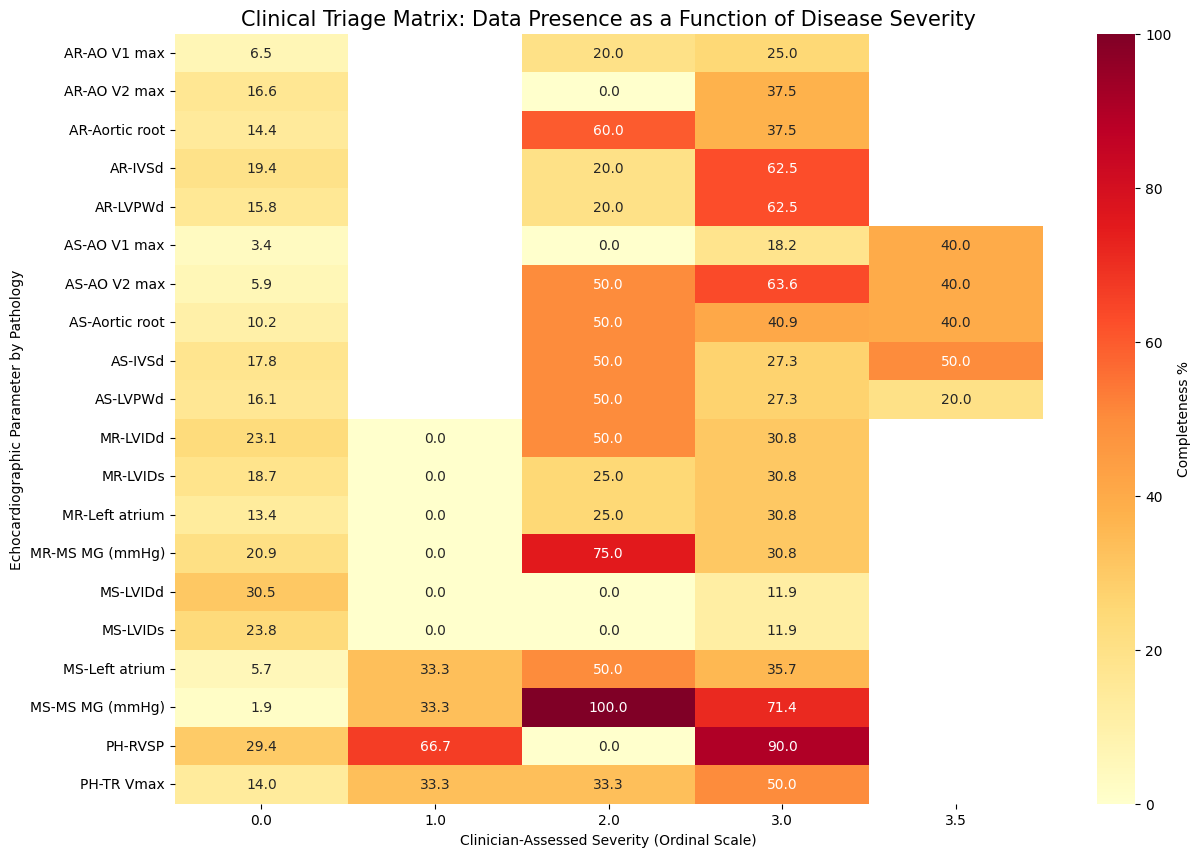

A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.


,ID,DoB,Age,Gender,Pre-procedure diagnosis,Post-procedure diagnosis,Year(s) since procedure,Medications,SBP R,DBP R,...,SGLT2_Inhibitors_name,SGLT2_Inhibitors_tdd,Pulmonary_Vasodilators_name,Pulmonary_Vasodilators_tdd,Lipid_Lowering_name,Lipid_Lowering_tdd,Anti_Ischemic_Other_name,Anti_Ischemic_Other_tdd,Metabolic_Endocrine_name,Metabolic_Endocrine_tdd
0,152,18-Sep-94,30,Male,"Bicuspid aortic valve, Secundum atrial septal ...",NaN,NaN,Tadalafil 20 mg QD | Metoprolol 50 mg QD | Spi...,98,63,...,None,0.0,Tadalafil,20.0,None,0.0,None,0.0,None,0.0
1,151,30-Nov-04,20,Female,Secundum atrial septal defect,NaN,NaN,Aspirin 100 mg QD,118,68,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
2,150,14-Sep-51,73,Female,"Left atrium thrombus, Moderate tricuspid regur...",NaN,NaN,Irbesartan 159 mg QD | Carvedilol 6.25 mg QD |...,144,93,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,149,28-Oct-09,15,Female,"Arrhythmogenic right ventricle dysplasia, Prim...",NaN,NaN,Sildenafil 25 mg BID,105,70,...,None,0.0,Sildenafil,50.0,None,0.0,None,0.0,None,0.0
4,148,26-Nov-06,18,Male,Mild intracavitary right ventricle muscle bund...,NaN,NaN,NaN,132,78,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0


In [88]:
'''
Step 4: Stratified Missingness & Triage Proxy Audit
'''
#Running the echo-specific audit on the 'Refined' data.
# This step proves that MNAR patterns follow clinical suspicion/severity.
missing_stratified = auditor(parsed).echo_missingness()

# Pivot for 'Triage Matrix' visualization. 
pivot_audit = missing_stratified.pivot_table(
    index=['Pathology', 'Parameter'], 
    columns='Severity', 
    values='Completeness_Pct' 
)
print("Stratified Completeness Matrix" + "\n" + "-"*40)
print("Rows: Pathology-Parameter pairs")
print("Columns: Clinical Severity (0.0 to 3.5)\n")
print(pivot_audit)

# --- Visualization: The Triage Silhouette ---
plt.figure(figsize=(14, 10))

# Using a sequential colormap (YlOrRd) to highlight 'Data Deserts' vs 'Data Oases'.
sns.heatmap(pivot_audit, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Completeness %'})

plt.title("Clinical Triage Matrix: Data Presence as a Function of Disease Severity", fontsize=15)
plt.xlabel("Clinician-Assessed Severity (Ordinal Scale)")
plt.ylabel("Echocardiographic Parameter by Pathology")
plt.show()
print("A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.")

# Final checkpoint before Stochastic Imputation:
# At this point, 'parsed' contains the 'Anatomy_Pre' and 'Sev_X' columns 
# required for the conditional baseline imputation logic.
parsed.head()

In [90]:
# 5. EXPLORATIONS
# ==========================================
parsed['Left atrium'].unique()

array([nan, 'Huge', 'Severely enlarged', 'Moderately enlarged',
       'Moderately enlargement', 'Severe enlargement',
       'Moderately dilated', 'Enlarged',
       'Severely enlarged | Moderately sized thrombus 2.5 cm',
       'Left atrium myxoma 56 x 33', 'Myxoma 3.9 x 1.7 cm',
       'Mild enlargement', 'Severely enlarged | Sludge', 'Moderate size',
       'Smoke | Thrombus 2.8 mm x 1.3 mm'], dtype=object)